In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# K-Means
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances_argmin_min
import umap
from scipy.optimize import linear_sum_assignment
from itertools import product

# Hierarchical
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering

# GMM
from sklearn.mixture import GaussianMixture

2024-12-20 14:41:06.717467: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Read in the data

In [2]:
top2017 = pd.read_csv("top2017.csv")
top2018 = pd.read_csv("top2018.csv")
big_songs = pd.read_csv("spotify_songs.csv")

In [3]:
top2019 = pd.read_csv("top2019.csv")

In [4]:
top1019 = pd.read_csv("top1019.csv")

In [5]:
# Number of unique artists in 2017 and 2018 top 100
unique_artists_2017 = len(set(top2017["artists"]))
print(f"Number of unique artists in 2017 top 100: {unique_artists_2017}")
unique_artists_2018 = len(set(top2018["artists"]))
print(f"Number of unique artists in 2018 top 100: {unique_artists_2018}")


# Number of songs in big dataset
unique_songs = len(set(big_songs["track_id"]))
print(f"\nNumber of unique songs in big dataset: {unique_songs}")
# Number of artists in big dataset
unique_artists = len(set(big_songs["track_artist"]))
print(f"Number of unique artists in big dataset: {unique_artists}")

Number of unique artists in 2017 top 100: 78
Number of unique artists in 2018 top 100: 70

Number of unique songs in big dataset: 28356
Number of unique artists in big dataset: 10693


There are 100 tracks in the top 2017 dataset, 100 tracks in the top 2018 dataset and 28,356 songs in the big dataset. There are 78 unique artists in the 2017 top 100, 70 artists in the 2018 top 100 and 10,693 in the large dataset. 

In [6]:
big_songs[big_songs["track_artist"] == "Noah Kahan"]

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
4044,7apizLyhMRutg3ccXvr2qv,Hurt Somebody,Noah Kahan,65,4tpVFjYKSR6ivXVK5YXEc4,Hurt Somebody,2018-01-12,POPTIMISM,6lWMi4lPiiPwDqn8ZpeyAY,pop,...,6,-5.135,1,0.3130,0.338,0.000000,0.262,0.473,114.983,168640
4391,6IW6mD0OrfYXXkTgdLBQ83,Cynic,Noah Kahan,64,3DNQrMjvVGiueVrj1qquJd,Busyhead,2019-06-14,2019 in Indie Poptimism,16RNbqnNCCLlBJti7JU5nc,pop,...,5,-5.634,1,0.0338,0.230,0.000001,0.325,0.962,103.007,208493
22424,7apizLyhMRutg3ccXvr2qv,Hurt Somebody,Noah Kahan,65,4tpVFjYKSR6ivXVK5YXEc4,Hurt Somebody,2018-01-12,urban CONTEMPORARY,1nFfDHtp8RY3obgen8KODl,r&b,...,6,-5.135,1,0.3130,0.338,0.000000,0.262,0.473,114.983,168640
22938,7nDFTHHwfe32a8qdp9XqPy,False Confidence,Noah Kahan,74,3DNQrMjvVGiueVrj1qquJd,Busyhead,2019-06-14,Pop Hits 2020,5TDtuKDbOhrfW7C58XnriZ,r&b,...,6,-7.770,1,0.0456,0.163,0.000000,0.138,0.330,108.980,223400


In [7]:
big_songs["id"] = big_songs["track_id"].str[:-1]
top2017_full = pd.merge(top2017, big_songs, left_on='id', right_on='id', how='inner')

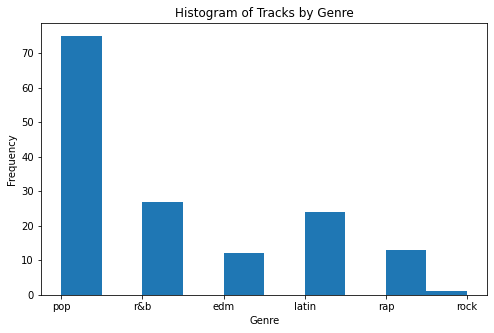

In [8]:
plt.figure(figsize=(8, 5))
plt.hist(top2017_full["playlist_genre"])
plt.title('Histogram of Tracks by Genre')
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.show()

In [9]:
big_songs["id"] = big_songs["track_id"].str[:-1]
top2018_full = pd.merge(top2018, big_songs, left_on='id', right_on='id', how='inner')

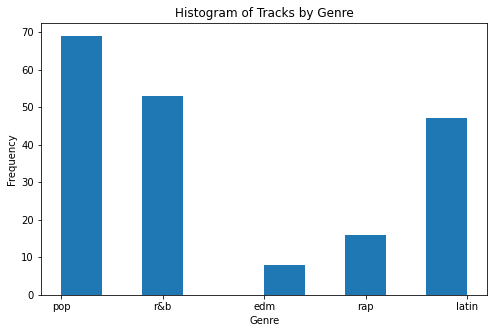

In [10]:
plt.figure(figsize=(8, 5))
plt.hist(top2018_full["playlist_genre"])
plt.title('Histogram of Tracks by Genre')
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.show()

In [11]:
for i in top2017.columns:
    print(i)

id
name
artists
danceability
energy
key
loudness
mode
speechiness
acousticness
instrumentalness
liveness
valence
tempo
duration_ms
time_signature


In [12]:
# These features describe the song
features = ["danceability", 
            "energy", 
            "loudness", 
            "speechiness", 
            "acousticness", 
            "instrumentalness", 
            "liveness", 
            "valence", 
            "tempo"]

In [13]:
top2018[features]

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.754,0.449,-9.211,0.1090,0.0332,0.000083,0.5520,0.3570,77.169
1,0.740,0.613,-4.880,0.1450,0.2580,0.003720,0.1230,0.4730,75.023
2,0.587,0.535,-6.090,0.0898,0.1170,0.000066,0.1310,0.1400,159.847
3,0.739,0.559,-8.011,0.1170,0.5800,0.000000,0.1120,0.4390,140.124
4,0.835,0.626,-5.833,0.1250,0.0589,0.000060,0.3960,0.3500,91.030
...,...,...,...,...,...,...,...,...,...
95,0.684,0.619,-7.005,0.0386,0.0716,0.000000,0.1220,0.2840,125.046
96,0.638,0.658,-6.318,0.0456,0.2450,0.000004,0.0919,0.3300,105.076
97,0.552,0.760,-4.706,0.3420,0.0733,0.000000,0.0865,0.6390,135.702
98,0.258,0.437,-6.593,0.0390,0.1010,0.000001,0.1060,0.0967,180.043


In [14]:
def make_histograms(data, features):
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    axes = axes.flatten()

    for i, feature in enumerate(features):
        axes[i].hist(data[feature], bins=20, color='blue', alpha=0.7, edgecolor='black')
        axes[i].set_title(feature)
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Frequency')

    for j in range(len(features), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

Show the histograms of the data

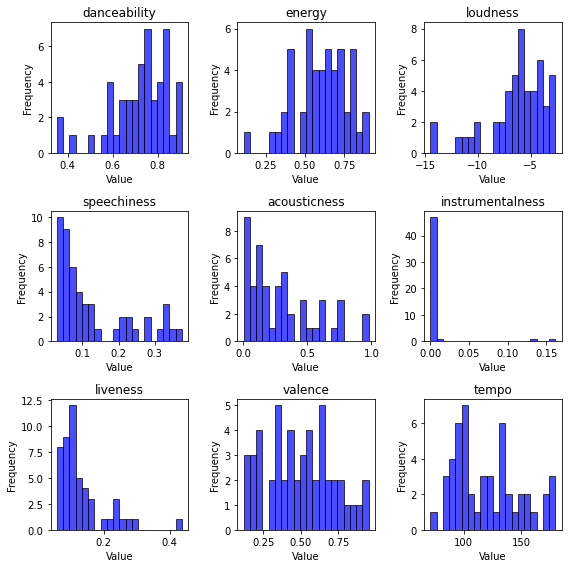

In [15]:
# make_histograms(top2017, features)
# make_histograms(top2018, features)
# make_histograms(big_songs, features)
make_histograms(top2019, features)

Do some analysis of top songs

In [16]:
top171819 = pd.concat([top2017, top2018, top2019])

In [17]:
top171819

,id,name,artists,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,7qiZfU4dY1lWllzX7mPBI,Shape of You,Ed Sheeran,0.825,0.652,1.0,-3.183,0.0,0.0802,0.5810,0.000000,0.0931,0.931,95.977,233713.0,4.0
1,5CtI0qwDJkDQGwXD1H1cL,Despacito - Remix,Luis Fonsi,0.694,0.815,2.0,-4.328,1.0,0.1200,0.2290,0.000000,0.0924,0.813,88.931,228827.0,4.0
2,4aWmUDTfIPGksMNLV2rQP,Despacito (Featuring Daddy Yankee),Luis Fonsi,0.660,0.786,2.0,-4.757,1.0,0.1700,0.2090,0.000000,0.1120,0.846,177.833,228200.0,4.0
3,6RUKPb4LETWmmr3iAEQkt,Something Just Like This,The Chainsmokers,0.617,0.635,11.0,-6.769,0.0,0.0317,0.0498,0.000014,0.1640,0.446,103.019,247160.0,4.0
4,3DXncPQOG4VBw3QHh3S81,I'm the One,DJ Khaled,0.609,0.668,7.0,-4.284,1.0,0.0367,0.0552,0.000000,0.1670,0.811,80.924,288600.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,7dt6x5M1jzdTEt8oCbisT,Better Now,Post Malone,0.680,0.578,10.0,-5.804,1.0,0.0400,0.3310,0.000000,0.1350,0.341,145.038,231267.0,4.0
46,4t9a07PAghtQMRAIP9FQ7,Soltera - Remix,Lunay,0.795,0.783,5.0,-4.271,1.0,0.0432,0.3610,0.000000,0.4370,0.800,92.016,266087.0,4.0
47,132ALUzVLmqYB4UsBj5qD,Adan y Eva,Paulo Londra,0.767,0.709,1.0,-4.470,1.0,0.3360,0.3230,0.000000,0.0745,0.720,171.993,256972.0,4.0
48,2qxmye6gAegTMjLKEBoR3,Let Me Down Slowly,Alec Benjamin,0.652,0.557,1.0,-5.714,0.0,0.0318,0.7400,0.000000,0.1240,0.483,150.073,169354.0,4.0


In [18]:
top171819[top171819["speechiness"] == max(top171819["speechiness"])]

,id,name,artists,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
91,6vN77lE9LK6HP2DewaN6H,Yes Indeed,Lil Baby,0.964,0.346,5.0,-9.309,0.0,0.53,0.035,0.0,0.108,0.562,119.958,142273.0,4.0


Add index for popularity for the top songs datasets

In [19]:
top2017["position"] = top2017.index + 1
top2018["position"] = top2018.index + 1

# Create a new feature list
features_with_position = ["danceability", 
                          "energy", 
                          "loudness", 
                          "speechiness", 
                          "acousticness", 
                          "instrumentalness", 
                          "liveness", 
                          "valence", 
                          "tempo",
                          "position"]

In [20]:
top2019["position"] = top2019.index + 1

Look at the correlation of the features

In [21]:
top2017[features_with_position].corr()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,position
danceability,1.000000,-0.057239,0.052759,0.111775,0.039398,-0.019826,-0.042014,0.423435,-0.364492,-0.086879
energy,-0.057239,1.000000,0.709141,-0.206672,-0.253051,0.101128,0.147744,0.321781,0.032676,-0.073636
loudness,0.052759,0.709141,1.000000,-0.443359,-0.153320,-0.057377,0.060033,0.407731,-0.136692,-0.057353
speechiness,0.111775,-0.206672,-0.443359,1.000000,-0.061942,-0.081229,-0.019815,-0.111576,0.172082,0.037783
acousticness,0.039398,-0.253051,-0.153320,-0.061942,1.000000,-0.074258,-0.135417,0.127241,-0.253404,0.016540
instrumentalness,-0.019826,0.101128,-0.057377,-0.081229,-0.074258,1.000000,-0.040742,-0.061523,0.148184,-0.094071
liveness,-0.042014,0.147744,0.060033,-0.019815,-0.135417,-0.040742,1.000000,-0.000645,0.049356,0.104806
valence,0.423435,0.321781,0.407731,-0.111576,0.127241,-0.061523,-0.000645,1.000000,-0.291877,-0.184857
tempo,-0.364492,0.032676,-0.136692,0.172082,-0.253404,0.148184,0.049356,-0.291877,1.000000,0.100124
position,-0.086879,-0.073636,-0.057353,0.037783,0.016540,-0.094071,0.104806,-0.184857,0.100124,1.000000


In [22]:
def make_correlation_heatmap(data, features, name):
    correlation_matrix = data[features].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title(f'Correlation Heatmap ({name})')
    plt.show()

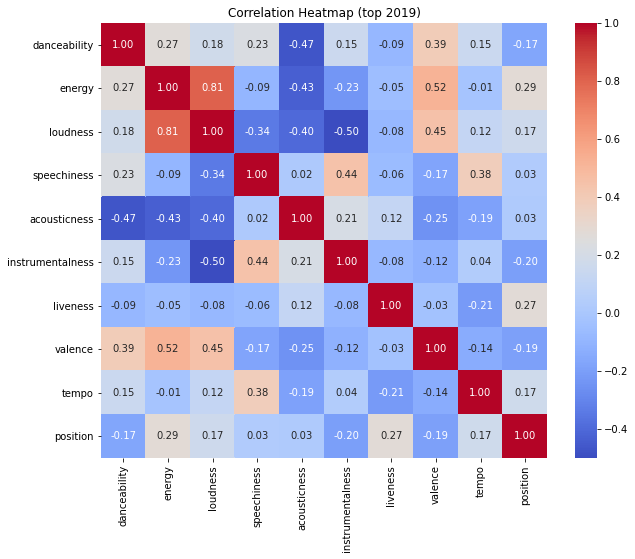

In [23]:
# make_correlation_heatmap(top2017, features_with_position, "top 2017")
# make_correlation_heatmap(top2018, features_with_position, "top 2018")
# make_correlation_heatmap(big_songs, features, "many songs")
make_correlation_heatmap(top2019, features_with_position, "top 2019")

## K-Means Clustering ##

In [105]:
def find_optimal_k(data, features, seed=1, num_clusters=30):
    X = data[features]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    inertia = []
#     silhouette_scores = []
    K_range = range(2, num_clusters)

    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=seed)
        kmeans.fit(X_scaled)
        inertia.append(kmeans.inertia_)
        score = silhouette_score(X_scaled, kmeans.labels_)
#         silhouette_scores.append(score)

    # Plot the Elbow Curve
    plt.figure(figsize=(8, 5))
    plt.plot(K_range, inertia, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.xticks(K_range)
    plt.grid(True)
    plt.show()


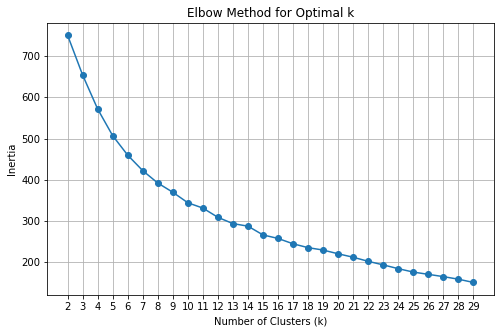

In [102]:
find_optimal_k(top2017, features, 4)

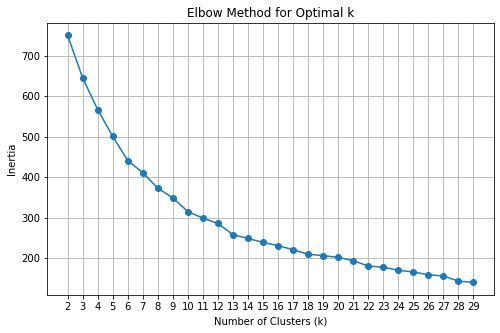

In [103]:
find_optimal_k(top2018, features)

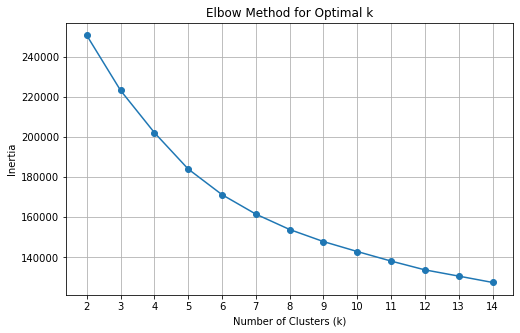

In [106]:
find_optimal_k(big_songs, features, num_clusters=15)

Going to use 11 clusters for both

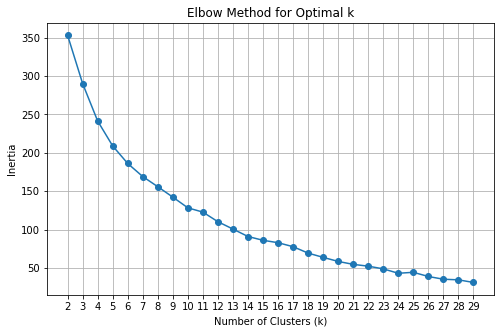

In [354]:
find_optimal_k(top2019, features)

11 for 2019 as well

In [107]:
km_2017 = KMeans(n_clusters=11)

In [50]:
def kmeans_and_closest(data, features, n_clusters, seed=3):
    X = data[features].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    kmeans = KMeans(n_clusters=n_clusters, random_state=seed)
    kmeans.fit(X_scaled)
    
    # get closest tracks to each centroid
    closest_indices, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, X_scaled)
    closest_points = data.iloc[closest_indices]
    
    # visualize the clusters 
    data["kmeans cluster"] = kmeans.fit_predict(X_scaled)
    
    # Use umap for visualization
    reducer = umap.UMAP(random_state=seed)
    embedding = reducer.fit_transform(X_scaled)
    
    palette = sns.color_palette("tab10", n_clusters)

    # Plot the UMAP results
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x=embedding[:, 0],
        y=embedding[:, 1],
        hue=data["kmeans cluster"],
        palette=palette,
        s=100
    )
    plt.title("UMAP Visualization of Clusters", fontsize=16)
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.legend(title="Cluster", loc="best", bbox_to_anchor=(1.05, 1), borderaxespad=0)
    plt.tight_layout()
    plt.show()
    
    return kmeans.cluster_centers_, closest_points, kmeans.labels_

In [422]:
def umap_alone(data, features, grouping, n_clusters=11, seed=3):
    X = data[features].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Use umap for visualization
    reducer = umap.UMAP(random_state=seed)
    embedding = reducer.fit_transform(X_scaled)
    palette = sns.color_palette("tab10", n_clusters)
    
    # Plot the UMAP results
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x=embedding[:, 0],
        y=embedding[:, 1],
        hue=data[grouping],
        palette=palette,
        s=100
    )
    plt.title("UMAP Visualization of Clusters", fontsize=16)
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.legend(title="Cluster", loc="best", bbox_to_anchor=(1.05, 1), borderaxespad=0)
    plt.tight_layout()
    plt.show()

In [39]:
def umap_only(data, features, method, seed=1, n_clusters=10):
    X = data[features].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    # Use umap for visualization
    reducer = umap.UMAP(random_state=seed)
    embedding = reducer.fit_transform(X_scaled)
    
    palette = sns.color_palette("tab10", n_clusters)


    # Plot the UMAP results
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x=embedding[:, 0],
        y=embedding[:, 1],
        hue=data[method],
        palette=palette,
        s=100
    )
    plt.title("UMAP Visualization of Clusters", fontsize=16)
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.legend(title="Cluster", loc="best", bbox_to_anchor=(1.05, 1), borderaxespad=0)
    plt.tight_layout()
    plt.show()

/Users/evangray/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


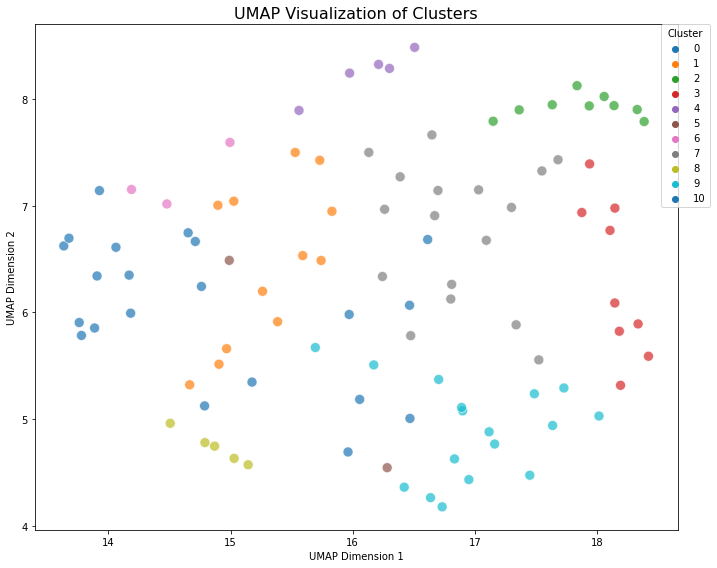


Closest Points:
                                        name           artists
87    Cold Water (feat. Justin Bieber & MØ)       Major Lazer
92                               Ahora Dice       Chris Jeday
97                    Body Like A Back Road          Sam Hunt
18  Rockabye (feat. Sean Paul & Anne-Marie)      Clean Bandit
14                                 Mask Off            Future
56   Pretty Girl - Cheat Codes X CADE Remix  Maggie Lindemann
99              Dusk Till Dawn - Radio Edit              ZAYN
64          No Promises (feat. Demi Lovato)       Cheat Codes
93                 Friends (with BloodPop®)     Justin Bieber
59                                24K Magic        Bruno Mars
27                      Scared to Be Lonely     Martin Garrix


In [141]:
centroids_2017, closest_points_2017, labels_2017 = kmeans_and_closest(top2017, features, n_clusters=11)

# Print results
# print("Centroids:\n", centroids_2017)
desc = ["name", "artists"]
print("\nClosest Points:\n", closest_points_2017[desc])

In [138]:
top2017["kmeans cluster"] = labels_2017

/Users/evangray/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


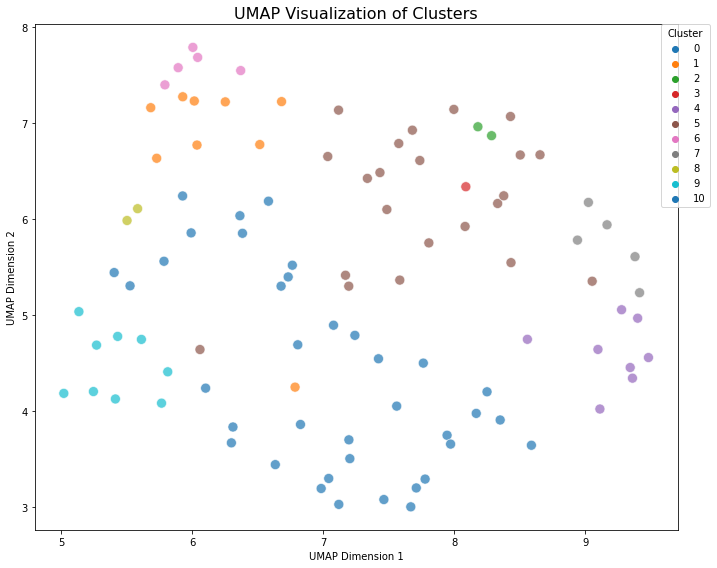


Closest Points:
                                                  name           artists
70  Let Me Go (with Alesso, Florida Georgia Line &...  Hailee Steinfeld
3                        Psycho (feat. Ty Dolla $ign)       Post Malone
93                                         This Is Me      Keala Settle
43                                            Thunder   Imagine Dragons
22                                               Mine             Bazzi
26                           Love Lies (with Normani)            Khalid
84                Perfect Duet (Ed Sheeran & Beyonc?)        Ed Sheeran
33                                          Nevermind      Dennis Lloyd
91                                         Yes Indeed          Lil Baby
58                                      XO TOUR Llif3      Lil Uzi Vert
30                               Taste (feat. Offset)              Tyga


In [140]:
centroids_2018, closest_points_2018, labels_2018 = kmeans_and_closest(top2018, features, n_clusters=11)
top2018["kmeans cluster"] = labels_2018

# Print results
# print("Centroids:\n", centroids_2018)
desc = ["name", "artists"]
print("\nClosest Points:\n", closest_points_2018[desc])

/Users/evangray/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


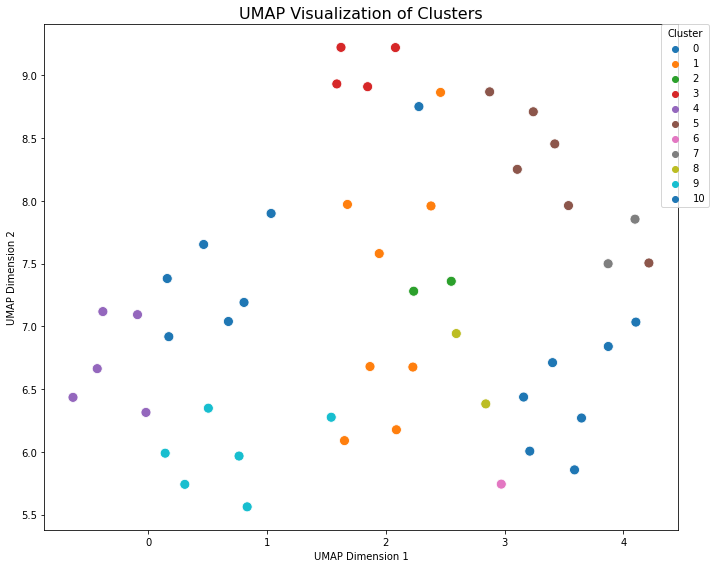


Closest Points:
                                       name        artists
16  Dancing With A Stranger (with Normani)      Sam Smith
18                           Old Town Road      Lil Nas X
17                           bury a friend  Billie Eilish
41                              Otro Trago           Sech
40                     If I Can't Have You   Shawn Mendes
45                              Better Now    Post Malone
46                         Soltera - Remix          Lunay
29                    lovely (with Khalid)  Billie Eilish
3                                  7 rings  Ariana Grande
39                                   China       Anuel AA
15                        Sweet but Psycho        Ava Max


In [381]:
centroids_2019, closest_points_2019, labels_2019 = kmeans_and_closest(top2019, features, n_clusters=11)

# Print results
# print("Centroids:\n", centroids_2017)
desc = ["name", "artists"]
print("\nClosest Points:\n", closest_points_2019[desc])

Group and sort by cluster so manually analyze how well this approach works

In [209]:
desc_cluster = ["name", "artists", "kmeans cluster"]
top2017_km_clusters = top2017[desc_cluster].sort_values(by = "kmeans cluster")

In [212]:
top2017_km_clusters[top2017_km_clusters["kmeans cluster"] == 0]

,name,artists,kmeans cluster
53,More Than You Know,Axwell /\ Ingrosso,0
24,Me Rehúso,Danny Ocean,0
15,Congratulations,Post Malone,0
98,Now Or Never,Halsey,0
87,Cold Water (feat. Justin Bieber & MØ),Major Lazer,0
88,Malibu,Miley Cyrus,0
11,Paris,The Chainsmokers,0
17,Castle on the Hill,Ed Sheeran,0
20,Mi Gente,J Balvin,0
79,Glorious (feat. Skylar Grey),Macklemore,0


In [214]:
desc_cluster = ["name", "artists", "kmeans cluster"]
top2018_km_clusters = top2018[desc_cluster].sort_values(by = "kmeans cluster")

In [215]:
top2018_km_clusters[top2018_km_clusters["kmeans cluster"] == 0]

,name,artists,kmeans cluster
34,?chame La Culpa,Luis Fonsi,0
25,Shape of You,Ed Sheeran,0
83,Vaina Loca,Ozuna,0
45,Jackie Chan,Ti?sto,0
46,Finesse (Remix) [feat. Cardi B],Bruno Mars,0
47,Back To You - From 13 Reasons Why ? Season 2 S...,Selena Gomez,0
78,Criminal,Natti Natasha,0
51,Happier,Marshmello,0
24,New Rules,Dua Lipa,0
77,"1, 2, 3 (feat. Jason Derulo & De La Ghetto)",Sofia Reyes,0


Now I am going to match up the centroids using linear sum assignment.

In [370]:
# centroids_2019
# centroids_2018
# centroids_2017

In [386]:
dist_2017_2018 = np.linalg.norm(centroids_2017[:, None, :] - centroids_2018[None, :, :], axis=2)
dist_2018_2019 = np.linalg.norm(centroids_2018[:, None, :] - centroids_2019[None, :, :], axis=2)

# Hungarian algorithm for matching
row_2017, col_2018 = linear_sum_assignment(dist_2017_2018)
row_2018, col_2019 = linear_sum_assignment(dist_2018_2019)

# Combine the matches into clusters
clusters = []
for i in range(len(row_2017)):
    cluster = (row_2017[i], col_2018[i], col_2019[i])
    clusters.append(cluster)


print("Cluster indices:")
for cluster in clusters:
    print(f"2017 index: {cluster[0]}, 2018 index: {cluster[1]}, 2019 index: {cluster[2]}")

Cluster indices:
2017 index: 0, 2018 index: 5, 2019 index: 9
2017 index: 1, 2018 index: 9, 2019 index: 4
2017 index: 2, 2018 index: 6, 2019 index: 5
2017 index: 3, 2018 index: 1, 2019 index: 2
2017 index: 4, 2018 index: 8, 2019 index: 6
2017 index: 5, 2018 index: 3, 2019 index: 10
2017 index: 6, 2018 index: 2, 2019 index: 7
2017 index: 7, 2018 index: 10, 2019 index: 0
2017 index: 8, 2018 index: 4, 2019 index: 8
2017 index: 9, 2018 index: 0, 2019 index: 3
2017 index: 10, 2018 index: 7, 2019 index: 1


Rename the clusters so they are the same if they align

In [401]:
dict_2018 = {}
dict_2019 = {}
for i in range(len(clusters)):
    dict_2018[i] = clusters[i][1]
    dict_2019[i] = clusters[i][2]

In [402]:
new_km_2018 = [dict_2018[i] for i in top2018["kmeans cluster"]]
new_km_2019 = [dict_2019[i] for i in top2019["kmeans cluster"]]

In [404]:
top2017["agg kmeans cluster"] = top2017["kmeans cluster"]
top2018["agg kmeans cluster"] = new_km_2018
top2019["agg kmeans cluster"] = new_km_2019

Clean and fix the other clusters

In [409]:
old_cols = ["kmeans cluster",
            "hierarchical cluster",
            "gmm cluster",
            "gmm cluster uncertainty",
            "Cluster"]
top171819 = pd.concat([top2017, top2018, top2019]).drop(columns = old_cols)
top171819

,id,name,artists,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,position,agg kmeans cluster
0,7qiZfU4dY1lWllzX7mPBI,Shape of You,Ed Sheeran,0.825,0.652,1.0,-3.183,0.0,0.0802,0.5810,0.000000,0.0931,0.931,95.977,233713.0,4.0,1,3
1,5CtI0qwDJkDQGwXD1H1cL,Despacito - Remix,Luis Fonsi,0.694,0.815,2.0,-4.328,1.0,0.1200,0.2290,0.000000,0.0924,0.813,88.931,228827.0,4.0,2,9
2,4aWmUDTfIPGksMNLV2rQP,Despacito (Featuring Daddy Yankee),Luis Fonsi,0.660,0.786,2.0,-4.757,1.0,0.1700,0.2090,0.000000,0.1120,0.846,177.833,228200.0,4.0,3,1
3,6RUKPb4LETWmmr3iAEQkt,Something Just Like This,The Chainsmokers,0.617,0.635,11.0,-6.769,0.0,0.0317,0.0498,0.000014,0.1640,0.446,103.019,247160.0,4.0,4,0
4,3DXncPQOG4VBw3QHh3S81,I'm the One,DJ Khaled,0.609,0.668,7.0,-4.284,1.0,0.0367,0.0552,0.000000,0.1670,0.811,80.924,288600.0,4.0,5,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,7dt6x5M1jzdTEt8oCbisT,Better Now,Post Malone,0.680,0.578,10.0,-5.804,1.0,0.0400,0.3310,0.000000,0.1350,0.341,145.038,231267.0,4.0,46,10
46,4t9a07PAghtQMRAIP9FQ7,Soltera - Remix,Lunay,0.795,0.783,5.0,-4.271,1.0,0.0432,0.3610,0.000000,0.4370,0.800,92.016,266087.0,4.0,47,7
47,132ALUzVLmqYB4UsBj5qD,Adan y Eva,Paulo Londra,0.767,0.709,1.0,-4.470,1.0,0.3360,0.3230,0.000000,0.0745,0.720,171.993,256972.0,4.0,48,2
48,2qxmye6gAegTMjLKEBoR3,Let Me Down Slowly,Alec Benjamin,0.652,0.557,1.0,-5.714,0.0,0.0318,0.7400,0.000000,0.1240,0.483,150.073,169354.0,4.0,49,10


Umap and clustering using newly calculated centroids

/Users/evangray/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


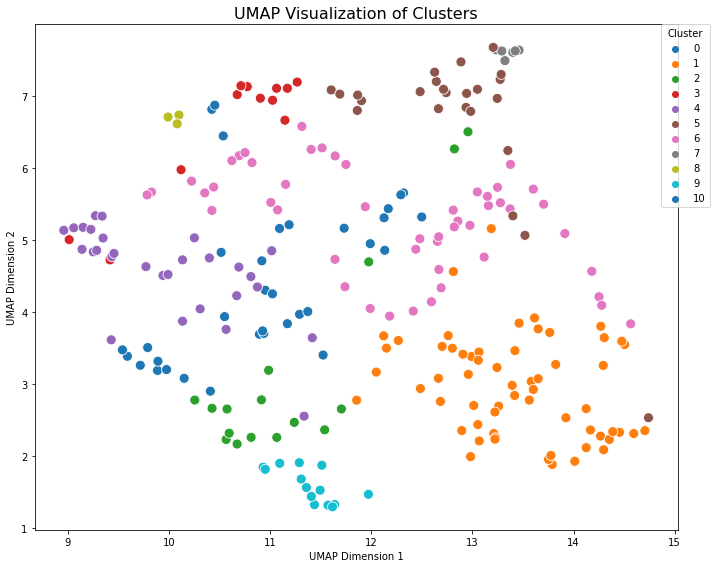

In [51]:
centroids_all, closest_points_all, labels_all = kmeans_and_closest(top171819, features, n_clusters=11)

/Users/evangray/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


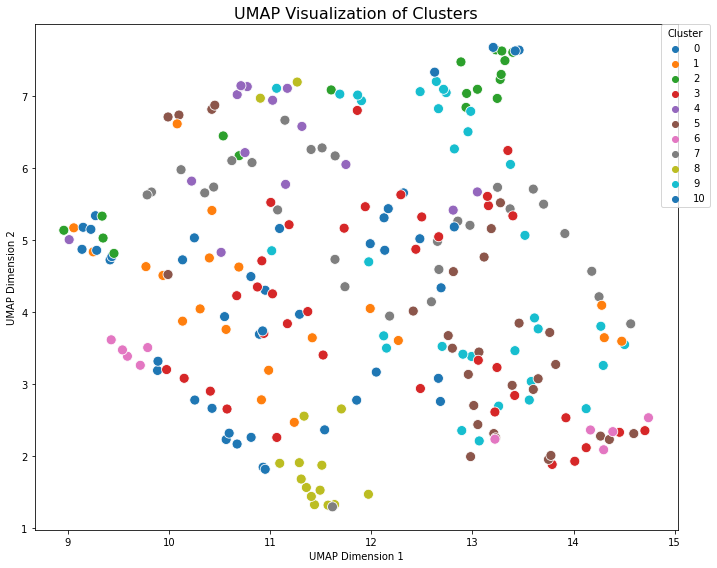

In [423]:
umap_alone(top171819, features, "agg kmeans cluster")

In [412]:
desc = ["name", "artists"]
print("\nClosest Points:\n", closest_points_all[desc])


Closest Points:
                                       name          artists
36                       Never Be the Same   Camila Cabello
39                                   China         Anuel AA
16                    no tears left to cry    Ariana Grande
55  FEFE (feat. Nicki Minaj & Murda Beatz)          6ix9ine
10                           XO TOUR Llif3     Lil Uzi Vert
22                            Dance Monkey      Tones And I
68                          What Lovers Do         Maroon 5
80                    lovely (with Khalid)    Billie Eilish
43                                 Thunder  Imagine Dragons
84               Otra Vez (feat. J Balvin)    Zion & Lennox
1                                  bad guy    Billie Eilish


Now calculate the similarity - take the most similar

In [48]:
def similarity(data, col1, col2):
    agg_clusters = data.groupby(col1)["id"].apply(set).to_dict()
    kmeans_clusters = data.groupby(col2)["id"].apply(set).to_dict()
    # Compute Jaccard similarities
    jaccard_matrix = {}
    for agg_label, kmeans_label in product(agg_clusters.keys(), kmeans_clusters.keys()):
        agg_set = agg_clusters[agg_label]
        kmeans_set = kmeans_clusters[kmeans_label]

        # Calculate the Jaccard similarity
        intersection = len(agg_set & kmeans_set)
        union = len(agg_set | kmeans_set)
        jaccard_similarity = intersection / union if union > 0 else 0

        # Store in matrix
        if agg_label not in jaccard_matrix:
            jaccard_matrix[agg_label] = {}
        jaccard_matrix[agg_label][kmeans_label] = jaccard_similarity

    # Visualization
    jaccard_df = pd.DataFrame(jaccard_matrix).T
    jaccard_df.index.name = col1
    jaccard_df.columns.name = col2

    # Display the Jaccard similarity matrix
    return jaccard_df

In [435]:
jacc = similarity(top171819, "kmeans cluster")

In [62]:
similarity(top171819, "kmeans cluster", "gmm cluster")

gmm cluster,0,1,2,3,4
kmeans cluster,,,,,
0,0.103774,0.000000,0.127451,0.050847,0.0
1,0.063830,0.027778,0.423077,0.043956,0.0
2,0.009434,0.033333,0.029412,0.268293,0.0
3,0.106383,0.120000,0.000000,0.000000,0.0
4,0.242105,0.024390,0.000000,0.050000,0.0
5,0.140000,0.085714,0.056604,0.000000,0.0
6,0.158333,0.050000,0.212389,0.024390,0.0
7,0.043478,0.052632,0.000000,0.000000,0.0
8,0.000000,0.000000,0.000000,0.000000,0.5


In [436]:
jacc

kmeans cluster,0,1,2,3,4,5,6,7,8,9,10
agg kmeans cluster,,,,,,,,,,,
0,0.155556,0.049383,0.050000,0.026316,0.177778,0.000000,0.042254,0.068966,0.000000,0.000000,0.000000
1,0.000000,0.039474,0.090909,0.000000,0.270270,0.000000,0.046154,0.000000,0.045455,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.100000,0.212121,0.015625,0.222222,0.000000,0.000000,0.052632
3,0.260000,0.129412,0.039216,0.000000,0.032258,0.052632,0.075949,0.000000,0.000000,0.000000,0.000000
4,0.025000,0.000000,0.000000,0.333333,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.328358,0.000000,0.000000,0.017857,0.000000,0.040000,0.000000,0.064516,0.000000,0.064516
6,0.093750,0.062500,0.000000,0.000000,0.028571,0.032258,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.051282,0.000000,0.000000,0.490196,0.000000,0.000000,0.024390,0.000000
8,0.000000,0.013699,0.033333,0.076923,0.024390,0.000000,0.000000,0.000000,0.000000,0.611111,0.000000


In [444]:
top171819[top171819["agg kmeans cluster"] == 8][desc]

,name,artists
26,Galway Girl,Ed Sheeran
44,Felices los 4,Maluma
54,One Dance,Drake
84,Otra Vez (feat. J Balvin),Zion & Lennox
93,Friends (with BloodPop®),Justin Bieber
6,I Like It,Cardi B
17,X,Nicky Jam
22,Mine,Bazzi
31,Solo (feat. Demi Lovato),Clean Bandit
41,Dura,Daddy Yankee


In [446]:
for i in jacc.columns:
    print(f"Aggregated Cluster: {i}, Aligned Cluster: {np.argmax(jacc[i])}, Similarity: {np.max(jacc[i]):.2f}")

Aggregated Cluster: 0, Aligned Cluster: 3, Similarity: 0.26
Aggregated Cluster: 1, Aligned Cluster: 5, Similarity: 0.33
Aggregated Cluster: 2, Aligned Cluster: 10, Similarity: 0.22
Aggregated Cluster: 3, Aligned Cluster: 4, Similarity: 0.33
Aggregated Cluster: 4, Aligned Cluster: 1, Similarity: 0.27
Aggregated Cluster: 5, Aligned Cluster: 9, Similarity: 0.22
Aggregated Cluster: 6, Aligned Cluster: 7, Similarity: 0.49
Aggregated Cluster: 7, Aligned Cluster: 2, Similarity: 0.22
Aggregated Cluster: 8, Aligned Cluster: 5, Similarity: 0.06
Aggregated Cluster: 9, Aligned Cluster: 8, Similarity: 0.61
Aggregated Cluster: 10, Aligned Cluster: 5, Similarity: 0.06


## Hierarchical Clustering ##

In [42]:
def make_dendrogram(data, features, thresh):
    X = data[features].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Perform hierarchical clustering linkage
    linked = linkage(X_scaled, method='ward')

    # Plot dendrogram
    plt.figure(figsize=(10, 7))
    dendrogram(linked, orientation='top', distance_sort='ascending', show_leaf_counts=True)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Samples')
    plt.xticks(rotation=90)
    plt.ylabel('Distance')
    plt.axhline(y=thresh, color='red', linestyle='--', label=f'Threshold = {thresh}')
    plt.show()

In [26]:
def get_cluster_labels(data, features, n_clusters):
    X = data[features].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Perform hierarchical clustering linkage
    linked = linkage(X_scaled, method='ward')

    n_clusters = n_clusters
    cluster_labels = fcluster(linked, n_clusters, criterion='maxclust')
    return cluster_labels

**2017**

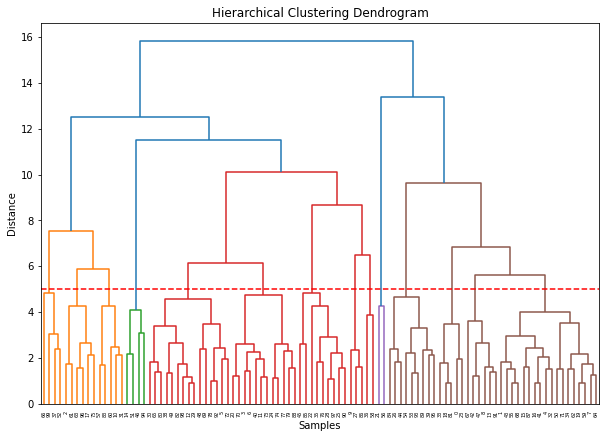

In [188]:
make_dendrogram(top2017, features, thresh=5)

Using a threshold of 5, there appears to be 14 major clusters. I used the branches that would create some variety while preserving differences.

In [207]:
top2017["hierarchical cluster"] = get_cluster_labels(top2017, features, n_clusters=14)
# top2017 = top2017.drop(columns = ["Cluster"])

In [216]:
desc_cluster = ["name", "artists", "hierarchical cluster"]
top2017_h_clusters = top2017[desc_cluster].sort_values(by = "hierarchical cluster")

In [217]:
top2017_h_clusters

,name,artists,hierarchical cluster
99,Dusk Till Dawn - Radio Edit,ZAYN,1
66,"How Far I'll Go - From ""Moana""",Alessia Cara,1
37,rockstar,Post Malone,1
52,Let Me Love You,DJ Snake,1
61,El Amante,Nicky Jam,2
...,...,...,...
62,You Don't Know Me - Radio Edit,Jax Jones,14
16,Swalla (feat. Nicki Minaj & Ty Dolla $ign),Jason Derulo,14
64,No Promises (feat. Demi Lovato),Cheat Codes,14
87,Cold Water (feat. Justin Bieber & MØ),Major Lazer,14


In [202]:
# Some cleaning of the data
# top2018 = top2018.drop(columns = ["cluster", "Cluster", "hierarchical clusters"])

**2018**

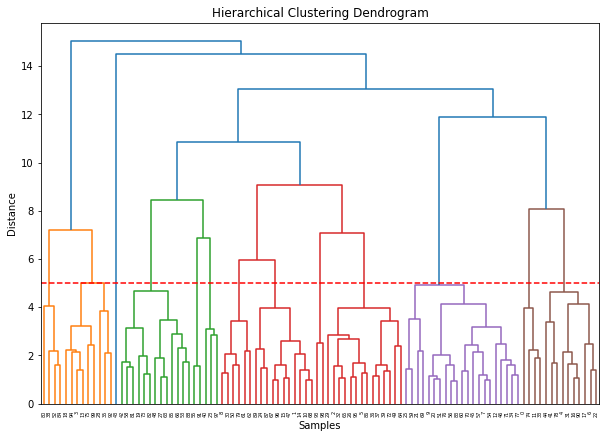

In [189]:
make_dendrogram(top2018, features, thresh=5)

Using a threshold of 5, there appears to be 13 major clusters. I used the branches that would create some variety while preserving differences.

In [218]:
top2018["hierarchical cluster"] = get_cluster_labels(top2018, features, n_clusters=13)
desc_cluster = ["name", "artists", "hierarchical cluster"]
top2018_h_clusters = top2018[desc_cluster].sort_values(by = "hierarchical cluster")

In [220]:
top2018_h_clusters

,name,artists,hierarchical cluster
38,changes,XXXTENTACION,1
80,lovely (with Khalid),Billie Eilish,1
84,Perfect Duet (Ed Sheeran & Beyonc?),Ed Sheeran,1
52,Too Good At Goodbyes,Sam Smith,1
3,Psycho (feat. Ty Dolla $ign),Post Malone,2
...,...,...,...
31,Solo (feat. Demi Lovato),Clean Bandit,12
4,In My Feelings,Drake,12
78,Criminal,Natti Natasha,12
17,X,Nicky Jam,12


**2019**

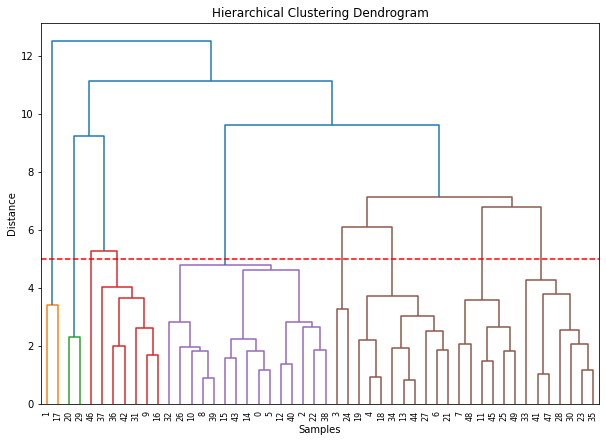

In [43]:
make_dendrogram(top2019, features, thresh=5)

In [29]:
top2019["hierarchical cluster"] = get_cluster_labels(top2019, features, n_clusters=14)

In [30]:
desc_cluster = ["name", "artists", "hierarchical cluster"]
top2019_h_clusters = top2019[desc_cluster].sort_values(by = "hierarchical cluster")

In [32]:
top2019_h_clusters

,name,artists,hierarchical cluster
1,bad guy,Billie Eilish,1
17,bury a friend,Billie Eilish,1
20,when the party's over,Billie Eilish,2
29,lovely (with Khalid),Billie Eilish,2
31,Going Bad (feat. Drake),Meek Mill,3
42,i'm so tired...,Lauv,3
36,Eastside (with Halsey & Khalid),benny blanco,3
9,Shallow,Lady Gaga,3
16,Dancing With A Stranger (with Normani),Sam Smith,3
37,Bohemian Rhapsody - 2011 Mix,Queen,4


**Overall Data**

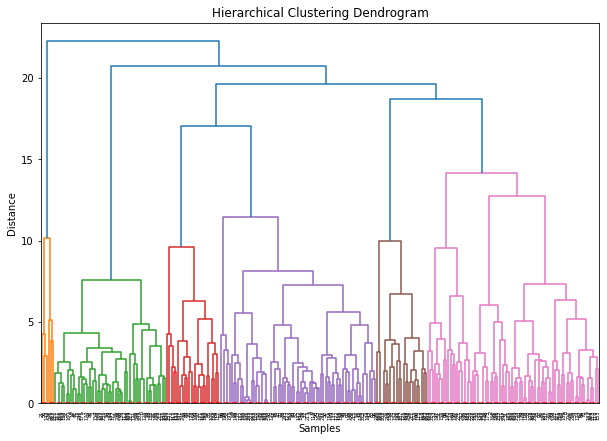

In [44]:
make_dendrogram(top171819, features, thresh=0)

In [45]:
top171819["hierarchical cluster"] = get_cluster_labels(top171819, features, n_clusters=6)
desc_cluster = ["name", "artists", "hierarchical cluster"]
top171819_h_clusters = top171819[desc_cluster].sort_values(by = "hierarchical cluster")

In [46]:
top171819_h_clusters

,name,artists,hierarchical cluster
1,bad guy,Billie Eilish,1
21,Thunder,Imagine Dragons,1
17,bury a friend,Billie Eilish,1
56,Pretty Girl - Cheat Codes X CADE Remix,Maggie Lindemann,1
43,Thunder,Imagine Dragons,1
...,...,...,...
61,El Amante,Nicky Jam,6
68,What Lovers Do,Maroon 5,6
62,You Don't Know Me - Radio Edit,Jax Jones,6
64,No Promises (feat. Demi Lovato),Cheat Codes,6


/Users/evangray/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


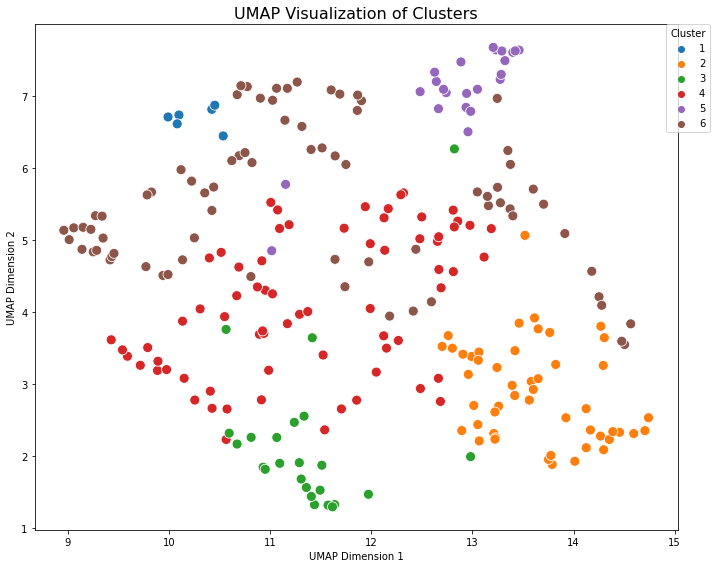

In [52]:
umap_only(top171819, features, "hierarchical cluster", n_clusters=6, seed=3)

## Gaussian Mixture Models ##

In [53]:
def build_gmm(data, features, n_components, seed=1):
    X = data[features].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=seed)
    gmm.fit(X_scaled)
    
    # get the clusters
    clusters = gmm.predict(X_scaled)
    
    # also get the uncertainty
    posterior_probs = gmm.predict_proba(X_scaled)
    uncertainty = 1 - np.max(posterior_probs, axis=1)
    return clusters, uncertainty

In [54]:
def get_optimal_components(data, features):
    X = data[features].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    bic_scores = []
    aic_scores = []
    n_components_range = range(1, 50)

    for n in n_components_range:
        gmm = GaussianMixture(n_components=n, random_state=2)
        gmm.fit(X)
        bic_scores.append(gmm.bic(X))
        aic_scores.append(gmm.aic(X))

    # Plot BIC and AIC scores
    plt.figure(figsize=(8, 6))
    plt.plot(n_components_range, bic_scores, label='BIC', marker='o')
    plt.plot(n_components_range, aic_scores, label='AIC', marker='o')
    plt.title('BIC and AIC Scores for GMM')
    plt.xlabel('Number of Components')
    plt.ylabel('Score')
    plt.legend()
    plt.show()

**2017**

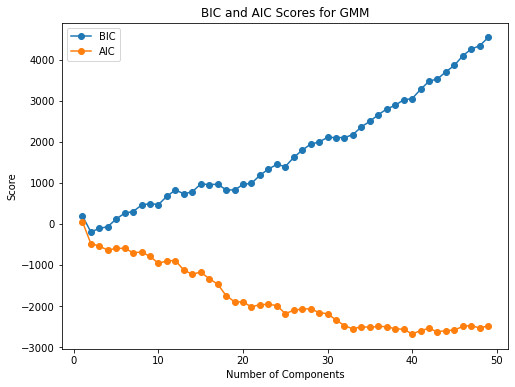

In [231]:
get_optimal_components(top2017, features)

Based on AIC, 18 appears to be a decent number of components. 32 might also be a good choice but the dataset is relatively small so it might be better to have fewer clusters.

In [252]:
clusters, uncertainty = build_gmm(top2017, features, n_components=18, seed=1)
top2017["gmm cluster"] = clusters
top2017["gmm cluster uncertainty"] = uncertainty
desc_cluster = ["name", "artists", "gmm cluster", "gmm cluster uncertainty"]
top2017_gmm_clusters = top2017[desc_cluster].sort_values(by = "gmm cluster")

In [253]:
top2017_gmm_clusters

,name,artists,gmm cluster,gmm cluster uncertainty
99,Dusk Till Dawn - Radio Edit,ZAYN,0,0.000000e+00
86,In the Name of Love,Martin Garrix,0,0.000000e+00
37,rockstar,Post Malone,0,0.000000e+00
27,Scared to Be Lonely,Martin Garrix,0,0.000000e+00
9,I Don’t Wanna Live Forever (Fifty Shades Darke...,ZAYN,0,0.000000e+00
...,...,...,...,...
20,Mi Gente,J Balvin,17,6.383049e-07
70,Sign of the Times,Harry Styles,17,0.000000e+00
11,Paris,The Chainsmokers,17,5.329071e-15
3,Something Just Like This,The Chainsmokers,17,0.000000e+00


**2018**

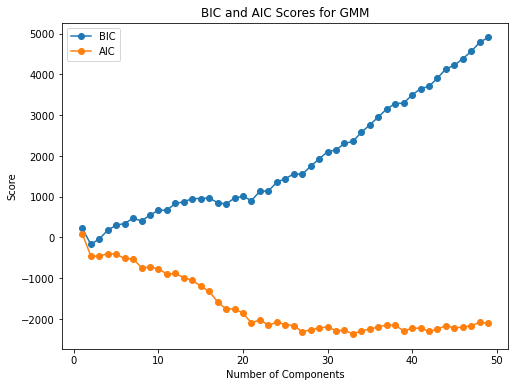

In [241]:
get_optimal_components(top2018, features)

Seems like 21 is the optimal number. I then tried components that had the cumulative uncertainty in each cluster below a given cluster. 

In [283]:
clusters, uncertainty = build_gmm(top2018, features, n_components=14, seed=1)
top2018["gmm cluster"] = clusters
top2018["gmm cluster uncertainty"] = uncertainty
desc_cluster = ["name", "artists", "gmm cluster", "gmm cluster uncertainty"]
top2018_gmm_clusters = top2018[desc_cluster].sort_values(by = "gmm cluster")

In [288]:
for i in range(14):
    print(sum(top2018_gmm_clusters[top2018_gmm_clusters["gmm cluster"] == i]["gmm cluster uncertainty"]))

4.474748179417176e-05
6.332712132461893e-12
0.0
0.0
4.834888045479602e-11
0.01985027509438908
0.029959733843437086
0.0040067471953616485
0.0
0.0
0.0
0.0
0.0
9.663448665708785e-07


In [58]:
for k in range(20):
    clusters, uncertainty = build_gmm(top171819, features, n_components=14, seed=1)
    top171819["gmm cluster"] = clusters
    top171819["gmm cluster uncertainty"] = uncertainty
    desc_cluster = ["name", "artists", "gmm cluster", "gmm cluster uncertainty"]
    top171819_gmm_clusters = top171819[desc_cluster].sort_values(by = "gmm cluster")
    items = []
    for i in range(k):
        items.append(sum(top171819_gmm_clusters[top171819_gmm_clusters["gmm cluster"] == i]["gmm cluster uncertainty"]))
    if all(items) < 0.05:
        print(k)

5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [59]:
clusters, uncertainty = build_gmm(top171819, features, n_components=5, seed=1)
top171819["gmm cluster"] = clusters
top171819["gmm cluster uncertainty"] = uncertainty

/Users/evangray/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


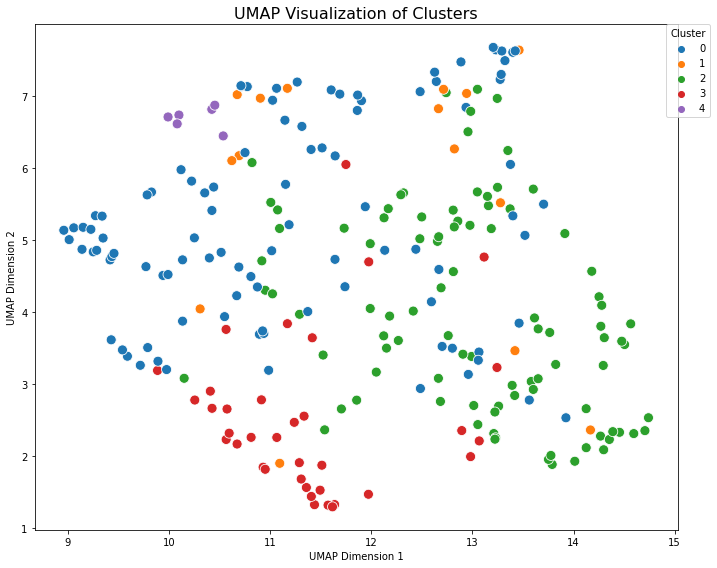

In [61]:

umap_only(top171819, features, "gmm cluster", n_clusters=5, seed=3)

Similarities

In [68]:
similarity(top171819, "hierarchical cluster", "gmm cluster")

gmm cluster,0,1,2,3,4
hierarchical cluster,,,,,
1,0.000000,0.000000,0.000000,0.000000,1.0
2,0.069231,0.032787,0.330097,0.037037,0.0
3,0.000000,0.054054,0.000000,0.578947,0.0
4,0.157895,0.012987,0.277311,0.100000,0.0
5,0.131313,0.125000,0.037736,0.000000,0.0
6,0.410256,0.072289,0.124138,0.018519,0.0


In [69]:
top171819[top171819["gmm cluster"] == 4]

,id,name,artists,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,hierarchical cluster,kmeans cluster,gmm cluster,gmm cluster uncertainty
21,0tKcYR2II1VCQWT79i5Nr,Thunder,Imagine Dragons,0.600,0.810,0.0,-4.749,1.0,0.0479,0.00683,0.210,0.155,0.298,167.880,187147.0,4.0,1,8,4,0.0
36,7hDc8b7IXETo14hHIHdnh,Passionfruit,Drake,0.809,0.463,11.0,-11.377,1.0,0.0396,0.25600,0.085,0.109,0.364,111.980,298941.0,4.0,1,10,4,0.0
56,1NDxZ7cFAo481dtYWdrUn,Pretty Girl - Cheat Codes X CADE Remix,Maggie Lindemann,0.703,0.868,7.0,-4.661,0.0,0.0291,0.15000,0.132,0.104,0.733,121.030,193613.0,4.0,1,8,4,0.0
43,1zB4vmk8tFRmM9UULNzbL,Thunder,Imagine Dragons,0.605,0.822,0.0,-4.833,1.0,0.0438,0.00671,0.134,0.147,0.288,167.997,187147.0,4.0,1,8,4,0.0
1,2Fxmhks0bxGSBdJ92vM42,bad guy,Billie Eilish,0.701,0.425,7.0,-10.965,1.0,0.3750,0.32800,0.130,0.100,0.562,135.128,194088.0,4.0,1,10,4,0.0
17,4SSnFejRGlZikf02HLewE,bury a friend,Billie Eilish,0.905,0.389,8.0,-14.505,1.0,0.3320,0.74000,0.162,0.106,0.196,120.046,193143.0,4.0,1,10,4,0.0


In [71]:
top171819[top171819["hierarchical cluster"] == 1]

,id,name,artists,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,hierarchical cluster,kmeans cluster,gmm cluster,gmm cluster uncertainty
21,0tKcYR2II1VCQWT79i5Nr,Thunder,Imagine Dragons,0.600,0.810,0.0,-4.749,1.0,0.0479,0.00683,0.210,0.155,0.298,167.880,187147.0,4.0,1,8,4,0.0
36,7hDc8b7IXETo14hHIHdnh,Passionfruit,Drake,0.809,0.463,11.0,-11.377,1.0,0.0396,0.25600,0.085,0.109,0.364,111.980,298941.0,4.0,1,10,4,0.0
56,1NDxZ7cFAo481dtYWdrUn,Pretty Girl - Cheat Codes X CADE Remix,Maggie Lindemann,0.703,0.868,7.0,-4.661,0.0,0.0291,0.15000,0.132,0.104,0.733,121.030,193613.0,4.0,1,8,4,0.0
43,1zB4vmk8tFRmM9UULNzbL,Thunder,Imagine Dragons,0.605,0.822,0.0,-4.833,1.0,0.0438,0.00671,0.134,0.147,0.288,167.997,187147.0,4.0,1,8,4,0.0
1,2Fxmhks0bxGSBdJ92vM42,bad guy,Billie Eilish,0.701,0.425,7.0,-10.965,1.0,0.3750,0.32800,0.130,0.100,0.562,135.128,194088.0,4.0,1,10,4,0.0
17,4SSnFejRGlZikf02HLewE,bury a friend,Billie Eilish,0.905,0.389,8.0,-14.505,1.0,0.3320,0.74000,0.162,0.106,0.196,120.046,193143.0,4.0,1,10,4,0.0
